In [26]:
import numpy as np
import cvxpy as cp
import control as ctrl
from scipy import sparse
import matplotlib.pyplot as plt
from math import sin, cos
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

In [27]:
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.81
l = 0.3

Ts = 1/10

A_22 = (-(I+m*l**2)*b)/(I*(M+m)+M*m*l**2)
A_23 = (m**2 * g * l**2)/ (I*(M+m) + M*m* l**2)
A_42 = (-m*l*b)/(I*(M+m) + M*m* l**2)
A_43 = ((m*g*l)*(M+m))/(I*(M+m) + M*m* l**2)
B_2 = (I + m*l**2)/(I*(M+m) + M*m*l**2)
B_4 = (m*l)/(I*(M+m) + M*m*l**2)

# State space matrices
A = np.array([[0, 1, 0, 0],
              [0, A_22, A_23, 0],
              [0, 0, 0, 1],
              [0, A_42, A_43, 0]])

B = np.array([[0],
              [B_2],
              [0],
              [B_4]])

C = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

D = np.array([[0],
              [0]])

In [28]:
#Construct a state-space system

sys_ss = ctrl.StateSpace(A, B, C, D)

In [29]:
sys_ss

StateSpace(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        , -0.18181818,  2.67545455,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        , -0.45454545, 31.21363636,  0.        ]]), array([[0.        ],
       [1.81818182],
       [0.        ],
       [4.54545455]]), array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]), array([[0.],
       [0.]]))

In [30]:
#Discretization of the state-space system
#with zero-order hold (ZOH) method
sys_discrete = ctrl.c2d(sys_ss, Ts, method='zoh')

In [31]:
A_zoh = np.array(sys_discrete.A)
B_zoh = np.array(sys_discrete.B)

In [32]:
sys_discrete, A_zoh, B_zoh

(StateSpace(array([[ 1.00000000e+00,  9.90913106e-02,  1.36466228e-02,
          4.50875049e-04],
        [ 0.00000000e+00,  9.81778455e-01,  2.79187747e-01,
          1.36466228e-02],
        [ 0.00000000e+00, -2.31848842e-03,  1.15996206e+00,
          1.05278915e-01],
        [ 0.00000000e+00, -4.74325089e-02,  3.27993476e+00,
          1.15996206e+00]]), array([[0.00908689],
        [0.18221545],
        [0.02318488],
        [0.47432509]]), array([[1., 0., 0., 0.],
        [0., 0., 1., 0.]]), array([[0.],
        [0.]]), 0.1),
 array([[ 1.00000000e+00,  9.90913106e-02,  1.36466228e-02,
          4.50875049e-04],
        [ 0.00000000e+00,  9.81778455e-01,  2.79187747e-01,
          1.36466228e-02],
        [ 0.00000000e+00, -2.31848842e-03,  1.15996206e+00,
          1.05278915e-01],
        [ 0.00000000e+00, -4.74325089e-02,  3.27993476e+00,
          1.15996206e+00]]),
 array([[0.00908689],
        [0.18221545],
        [0.02318488],
        [0.47432509]]))

In [33]:
# Intialization of MPC

[nx, nu] = B_zoh.shape

Q = sparse.diags([10., 5., 100., 5.])
R = np.array([[.1]])
# Compute LQR terminal cost for stability

x0 = np.array([-1.5, -1., 0.65, 0.5])  # Initial conditions

xr = np.array([0., 0., 0., 0.])  # Desired states
# xr *= -1

N = 10  # MPC Horizon length

x = cp.Variable((nx, N+1))
u = cp.Variable((nu, N))
x_init = cp.Parameter(nx)

nsim = 70  # Number of simulation timesteps
time = [0.]
cart_pos = [x0[0]]
cart_vel = [x0[1]]
pend_ang = [x0[2]]
pend_ang_vel = [x0[3]]
ctrl_effort = []

In [34]:
# Define the MPC
def run_mpc():
    cost = 0.                                                       # From B: Initialize cost to zero
    constr = [x[:, 0] == x_init]                                    # From D: Initial state constraint
    
    for t in range(N):
        cost += cp.quad_form(x[:, t] - xr, Q) + cp.quad_form(u[:, t], R)  # From E: Stage cost
        constr += [cp.norm(u[:, t], 'inf') <= 10.]                  # From C: Input constraint
        constr += [x[:, t + 1] == A_zoh @ x[:, t] + B_zoh @ u[:, t]]  # From F: Dynamics constraint

    cost += cp.quad_form(x[:, N] - xr, Q)                           # From A: Terminal cost
    problem = cp.Problem(cp.Minimize(cost), constr)
    return problem




Initial condition for MPC

$x(0) == x_{init}$

Prediction in MPC loop

$ x_{t+1} == A_{discrete} * x(t) + B_{discrete} * u(t)$

In [ ]:
dt = Ts
total_effort = 0
for i in range(1, nsim+1):
    prob = run_mpc()
    x_init.value = x0
    print('TIME: ', round(i*dt, 2), 'STATES: ', [round(state, 2) for state in x0])
    prob.solve(solver=cp.OSQP, warm_start=True)
    
    # Store current states
    time.append(i)
    cart_pos.append(x0[0])
    cart_vel.append(x0[1])
    pend_ang.append(x0[2])
    pend_ang_vel.append(x0[3])
    
    # Extract the optimal control input
    u_optimal = u[:, 0].value
    
    # Store the control effort
    ctrl_effort.append(u_optimal)
    
    # Update total effort (absolute value)
    total_effort += abs(u_optimal)
    
    # Update the state for the next iteration using the system dynamics
    x0 = A_zoh @ x0 + B_zoh @ u_optimal
    print("Control Effort: ", u_optimal)

print("Total control effort: ", total_effort)



TIME:  0.1 STATES:  [-1.5, -1.0, 0.65, 0.5]
TIME:  0.2 STATES:  [-1.68, -2.62, 0.58, -1.98]
TIME:  0.3 STATES:  [-2.02, -4.26, 0.23, -5.03]
TIME:  0.4 STATES:  [-2.41, -3.43, -0.15, -2.91]
TIME:  0.5 STATES:  [-2.71, -2.55, -0.36, -1.37]
TIME:  0.6 STATES:  [-2.92, -1.77, -0.45, -0.43]
TIME:  0.7 STATES:  [-3.07, -1.11, -0.46, 0.11]
TIME:  0.8 STATES:  [-3.15, -0.55, -0.44, 0.4]
TIME:  0.9 STATES:  [-3.18, -0.09, -0.39, 0.53]
TIME:  1.0 STATES:  [-3.17, 0.29, -0.34, 0.57]
TIME:  1.1 STATES:  [-3.13, 0.59, -0.28, 0.56]
TIME:  1.2 STATES:  [-3.05, 0.83, -0.23, 0.52]
TIME:  1.3 STATES:  [-2.96, 1.01, -0.18, 0.47]
TIME:  1.4 STATES:  [-2.85, 1.15, -0.14, 0.41]
TIME:  1.5 STATES:  [-2.74, 1.24, -0.1, 0.36]
TIME:  1.6 STATES:  [-2.61, 1.3, -0.07, 0.3]
TIME:  1.7 STATES:  [-2.48, 1.34, -0.04, 0.25]
TIME:  1.8 STATES:  [-2.34, 1.35, -0.02, 0.21]
TIME:  1.9 STATES:  [-2.21, 1.35, -0.0, 0.17]
TIME:  2.0 STATES:  [-2.07, 1.33, 0.01, 0.14]
TIME:  2.1 STATES:  [-1.94, 1.29, 0.03, 0.11]
TIME:  2.2 S

$ x_{0} = A_{discrete} * x(t) + B_{discrete} * u(t)$

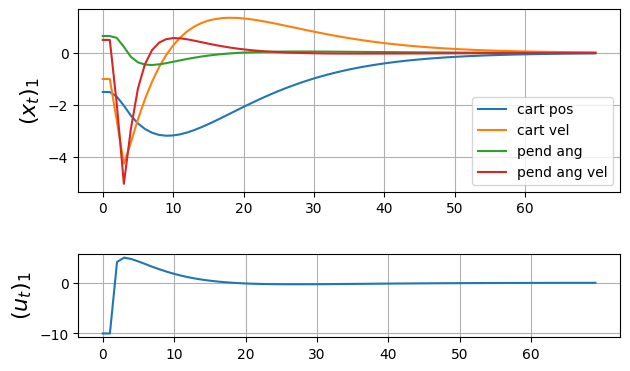

In [36]:
def plot_results():
    f = plt.figure()
    ax = f.add_subplot(211)
    plt.plot(cart_pos, label='cart pos')
    plt.plot(cart_vel, label='cart vel')
    plt.plot(pend_ang, label='pend ang')
    plt.plot(pend_ang_vel, label='pend ang vel')
    plt.ylabel(r"$(x_t)_1$", fontsize=16)
    plt.xticks([t_step for t_step in range(nsim) if t_step % 10 == 0])
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 3)
    plt.plot(ctrl_effort)
    plt.ylabel(r"$(u_t)_1$", fontsize=16)
    plt.xticks([t_step for t_step in range(nsim) if t_step % 10 == 0])
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    
    
plot_results()

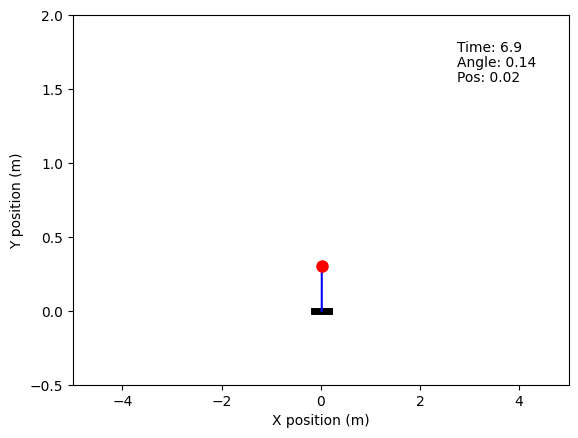

In [37]:
def animated_plot():
    fig = plt.figure()
    ax = plt.axes(xlim=(-5., 5.), ylim=(-.5, 2.))
    time_text = ax.text(2.75, 1.75, '')
    angle_text = ax.text(2.75, 1.65, '')
    pos_text = ax.text(2.75, 1.55, '')
    times = range(nsim)

    def update(i):
        time_text.set_text("Time: {0:0}".format(round(times[i]*dt, 2)))
        angle_text.set_text("Angle: {0:0.2f}".format(pend_ang[i]*57.3))
        pos_text.set_text("Pos: {0:0.2f}".format(-cart_pos[i]))

        cart_x = -cart_pos[i]
        pend_pos = pend_ang[i]
        pendulum_x0 = cart_x
        pendulum_y0 = 0.
        pendulum_x1 = cart_x + l*sin(pend_pos)
        pendulum_y1 = l*cos(pend_pos)

        cart.set_data([cart_x-.15, cart_x+.15], [0., 0.])
        pend.set_data([pendulum_x0, pendulum_x1], [pendulum_y0, pendulum_y1])
        # Fix: Wrap single values in lists to make them sequences
        ball.set_data([pendulum_x1], [pendulum_y1])
        return (cart, pend, ball)

    cart, = plt.plot([], [], 'black', linewidth=5.)
    pend, = plt.plot([], [], 'b-')
    ball, = plt.plot([], [], 'ro', markersize=8.)
    plt.xlabel('X position (m)')
    plt.ylabel('Y position (m)')
    line_ani = animation.FuncAnimation(fig, update, int(nsim), interval=100, repeat=True, blit=True)
    
    # Try using a specific writer
    try:
        from matplotlib.animation import PillowWriter
        line_ani.save('mpc.gif', writer=PillowWriter(fps=10))
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Displaying animation without saving...")
    
    plt.show()

animated_plot()